# Proyecto II : Análisis de mercado inmobiliario
## Ingeniería de features, modelos avanzados e interpretación de modelos

### Introducción:

En este proyecto se pretende profundizar lo desarrollado en el Proyecto I aplicando transformación de datos, optimización de hiperparámetros y modelos avanzados para generar un modelo que tenga un mejor desempeño comparado con el modelo del Proyecto I. En el proyecto I, una vez explorado el dataset de Properati, se utilizaron herramientas básicas de Machine Learning (ML) para generar un modelo simple que prediga el precio de inmuebles. En esta oportunidad se busca mejorar dicho modelo para predecir esta variable. Luego, se propone interpretar los resultados obtenidos buscando aprender de nuestro problema estudiando el modelo que generamos.

Operativamente dividimos este proyecto en tres partes:

**PARTE A. Transformación de datos:**

Se llevará a cabo la eliminación de valores atípicos, la imputación de valores faltantes, el encoding de variables categóricas, el escaldo de los datos y la generación de nuevas variables predictoras. Además, se propone volver a entrenar un modelo de árboles de decisión utilizando los datos transformados.

**PARTE B. Modelos avanzados.**

Se entrenarán modelos avanzados para resolver el problema planteado. Se optimizarán sus hiperparámetros y se comparará su desempeño con los modelos entrendados en el Proyecto I y con el modelo entrenado en la parte A.

**PARTE C. Interpretación de modelos.**

De acuerdo a lo que el modelo nos permita se buscará responder las siguientes preguntas: ¿qué variables fueron relevantes para el modelo para hacer una predicción? ¿Cuáles no? ¿Cómo es la distribución de errores? ¿Dónde falla? ¿A qué se debe?

**DESAFIO OPCIONAL**

Aplicar una técnica de clustering al dataset. ¿Qué clusters se encuentran? ¿A qué pueden corresponder? ¿Qué barrios se parecen más entre sí? ¿Qué tipos de propiedad se parecen más entre sí?


### Parte A. Transformación de datos.

1) Importing:

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

2) Levantamos el dataset

In [89]:
df = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')

3) Preprocesamiento de los datos

Dado que debemos comparar los resultados obtenidos en este proyecto con el proyecto anterior, se decidió mantener los mismos filtros utilizados en el proyecto I:

* Se seleccionan propiedades que pertenecen a Capital Federal y que son "Departamento", "Casa" o "PH".
* Se filtra el dataset para que cumpla con la condición de que la superficie cubierta no puede ser mayor a la superficie total.
* Se seleccionan aquellas propiedades cuya superficie total es menor a 1000 m2 y mayor a 15 m2.
* Se seleccionan aquellas propiedades cuyo precio es menor a 4000000 dólares
* Se remueven los valores atípicos utilizando el método del rango intercuartílico.

Además se eliminarán los datos duplicados.

In [90]:
# Eliminación de datos duplicados
df.drop_duplicates(inplace=True)

In [91]:
# Filtrado del Dataset por lugar y tipo de propiedad
df2 = df.loc[(df['l2'] == 'Capital Federal') & ((df['property_type']== 'Departamento') | (df['property_type']== 'Casa') | (df['property_type']== 'PH')) ]

In [92]:
# Corrección del dataset por valores de superficie cubierta
df3 = df2[(df2['surface_covered'] <= df2['surface_total'])]

In [93]:
# Se seleccionan aquellas propiedades cuya superficie total es menor a 1000 m2 y mayor a 15 m2
mask = np.logical_and(df3.surface_total <= 1000, df3.surface_total >= 15)
df4 = df3[mask]
df4.shape

(79744, 19)

In [94]:
# Se seleccionan aquellas propiedades cuyo precio sea menor a 4000000 de dólares
mask2 = df4.price <= 4000000
df4 = df4[mask2]
df4.shape

(79713, 19)

In [95]:
# Selección de features relevantes a la problematica
df5 = df4[['l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price', 'property_type']]

In [96]:
# Filtramos el dataset eliminando outliers
# Para ello definimos una función que permita eliminar outliers mediante el criterio del valor intercuartilico

def remove_outliers(dfx):
    q1 = dfx.quantile(0.25)
    q3 = dfx.quantile(0.75)
    iqr = q3 - q1
    cut_off = iqr*1.5
    
    df_filtred = dfx[~((dfx < (dfx.quantile(0.25) - cut_off)) | (dfx > (dfx.quantile(0.75) + cut_off))).any(axis=1)]
    
    
    return df_filtred

In [97]:
#Aplicamos la funcion y eliminamos los valores atipicos utilizando el criterio del valor intercuartilico
df6 = remove_outliers(df5)

In [98]:
df6= df6.reset_index(drop=True)

In [99]:
df6.isna().sum()

l3                   0
rooms                0
bedrooms             0
bathrooms          728
surface_total        0
surface_covered      0
price                0
property_type        0
dtype: int64

Luego del proceso de filtrado del dataset y de la selección de features relevantes a la problematica planteada, observamos que existen 728 valores nulos (NaN) en la columna "bathrooms". 

4) Imputación de valores faltantes

Ante la presencia de datos faltantes tenemos dos opciones: eliminarlos o imputarlos. Eliminarlos puede traer como consecuencia la pérdida de datos importantes por lo que una mejor alternativa sería imputarlos con algún valor que sea coherente con el tipo de variable a imputar.

In [100]:
df6.bathrooms.describe()

count    68568.000000
mean         1.350703
std          0.569004
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          3.000000
Name: bathrooms, dtype: float64

Observamos que la variable "bathrooms"  toma como valor máximo 3 y como valor mínimo 1. 
Como se trata de una variable que puede tomar valores discretos entre 1 y 3, se buscará cual el el valor más frecuente según el tipo de propiedad para imputar los valores faltantes.

In [101]:
# Buscamos los valores más frecuentes de la variable "bathrooms" según el tipo de propiedad
most_frequent_baño = df6.groupby(['property_type'])['bathrooms'].agg(pd.Series.mode)
most_frequent_baño = dict(most_frequent_baño)

In [102]:
columnas_df6 = df6.columns.tolist()

In [103]:
# Imputación de valores faltantes 
df6.bathrooms = df6.bathrooms.fillna(df6.property_type.map(most_frequent_baño)) 

In [104]:
# Chequeamos
df6.isnull().sum()

l3                 0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
price              0
property_type      0
dtype: int64

In [105]:
df6 = df6.reset_index(drop=True)

In [106]:
df6.to_csv('df6_proyecto2.csv', index=False) # Guardamos el dataframe 

5) Enconding and Feature Scaling

In [107]:
df6.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,69296.000000,69296.000000,69296.000000,69296.000000,69296.000000,69296.000000
mean,2.740028,1.795428,1.347264,73.316555,64.524561,187062.070437
std,1.011669,0.848321,0.567202,34.960422,29.035983,92785.388993
min,1.000000,0.000000,1.000000,15.000000,2.000000,7500.000000
25%,2.000000,1.000000,1.000000,47.000000,42.000000,119000.000000
50%,3.000000,2.000000,1.000000,65.000000,57.000000,165000.000000
75%,3.000000,2.000000,2.000000,90.000000,80.000000,235500.000000
max,7.000000,6.000000,3.000000,200.000000,171.000000,512299.000000


En el dataframe encontramos variables categóricas. Como los modelos "entienden de números" y para no descartar características útiles para resolver nuestro problema, se lleva a cabo el ecodeo de dichas variables. Por otra parte, observamos la presencia de variables numéricas con valores muy dispares. Esto puede ocasionar problemas con algoritmos que implementan la distancia euclidiana. El escalado de los datos mejoraría el desempeño de los algoritmos estadísticos ya que se garantiza que todas las features "pesen" igual.

In [108]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [109]:
# Separamos el dataset en features y target

X = df6.drop('price', axis=1)
y = df6.price
X.head()

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type
0,Boedo,2.0,1.0,2.0,70.0,58.0,PH
1,Palermo,2.0,1.0,1.0,45.0,45.0,PH
2,Palermo,2.0,1.0,1.0,85.0,50.0,PH
3,Villa Crespo,2.0,1.0,1.0,56.0,56.0,PH
4,Villa Crespo,2.0,1.0,1.0,70.0,70.0,PH


In [110]:
# Separamos las features en categóricas y numéricas

X_cat = X[['l3', 'property_type']]
categorical_columns = ['l3', 'property_type']

X_num = X[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']]
numerical_columns = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']

# Encodeamos las variables categóricas 
ct = ColumnTransformer([('ohe', OneHotEncoder(sparse=False), categorical_columns)], remainder='passthrough')

In [111]:
X_cat_ct = ct.fit_transform(X_cat)

In [112]:
X_cat_ct.shape

(69296, 60)

In [113]:
X_cat_ct_df = pd.DataFrame(X_cat_ct)
X_cat_ct_df.columns = ct.get_feature_names()

In [114]:
X = pd.concat([X_cat_ct_df, X_num], axis=1)


In [115]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)



In [116]:
X_train = X_train.reset_index(drop=True)
X_train_num = X_train[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']]

In [117]:
scaler = StandardScaler()

In [118]:
# Escalamos las variables numéricas del set de train

X_train_num_scaled = pd.DataFrame(scaler.fit_transform(X_train_num), columns=numerical_columns)
X_train_num_scaled.head() 

,rooms,bedrooms,bathrooms,surface_total,surface_covered
0,-0.726708,-0.933934,-0.612749,-0.237720,-0.259220
1,1.239412,1.417577,1.142910,1.474717,2.067975
2,1.239412,1.417577,-0.612749,0.190389,0.185684
3,-0.726708,-0.933934,-0.612749,-0.637289,-0.977913
4,0.256352,0.241822,-0.612749,-0.294802,-0.122327


In [119]:
X_train_new = pd.concat([X_train.drop(numerical_columns, axis=1), X_train_num_scaled], axis=1)


In [120]:
# Transformamos el set de test

X_test = X_test.reset_index(drop=True)
X_test_num = X_test[numerical_columns]
X_test_num_scaled = pd.DataFrame(scaler.transform(X_test_num), columns=numerical_columns)
X_test_new = pd.concat([X_test.drop(numerical_columns, axis=1), X_test_num_scaled], axis=1)

**Generación de nuevas variables predictoras / Reducción de dimensionalidad**

In [121]:
from sklearn.decomposition import PCA

In [122]:
pca = PCA(n_components=0.95) # 95% de la varianza

In [123]:
X_train_nuevo = pca.fit_transform(X_train_new) 

In [124]:
X_test_nuevo = pca.transform(X_test_new)

In [125]:
column_pca_labels = []

for i in range(0,19):
    column_pca_labels.append('PC'+ str(i+1))


In [126]:
X_test_pca_df = pd.DataFrame(data=X_test_nuevo, columns=column_pca_labels)
X_test_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
0,-1.664531,-0.053341,0.152240,-0.150826,0.848878,0.061135,0.037085,0.095182,0.022474,0.118709,-0.028881,0.057560,-0.007799,-0.013336,0.011834,-0.015974,0.012430,0.008615,0.003173
1,-0.897998,0.666643,-1.053148,0.027850,-0.054710,-0.072056,0.098623,0.018862,-0.072973,0.062317,0.095125,-0.084060,-0.017890,0.055199,-0.065471,0.086307,-0.105067,-0.028011,0.000380
2,-0.535095,-1.571163,0.170637,0.043888,-0.127314,-0.009233,-0.078866,-0.057730,-0.032764,0.156261,-0.005196,-0.140429,-0.019777,0.103894,-0.056792,0.066100,-0.112415,-0.026266,0.017340
3,-0.424439,0.664689,-0.569274,-0.116091,-0.171352,-0.230813,0.433625,-0.453475,0.540354,0.134690,-0.311406,0.169602,0.033056,-0.056370,0.013294,-0.019627,0.025007,-0.000402,-0.001423
4,-0.632280,0.675417,-0.769309,-0.039267,-0.067617,-0.073113,0.057214,-0.026888,-0.076136,0.038685,0.076374,-0.107033,-0.019097,0.069929,-0.080710,0.116626,-0.160082,-0.047030,-0.015267


In [127]:
loadings = pca.components_.T
df_loadings = pd.DataFrame(loadings, columns=column_pca_labels, index=X_train_new.columns)
df_loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
ohe__x0_Abasto,0.000454,0.001288,-0.005165,0.000805,-0.003440,-0.003340,0.002909,-0.001867,-0.002908,-0.004913,0.007276,-0.011515,-0.002232,0.009964,-0.010009,0.016620,-0.024280,-0.007886,-0.000626
ohe__x0_Agronomía,-0.000140,0.000060,0.001197,0.003675,-0.001123,-0.000125,0.002763,0.001837,-0.000484,-0.000725,0.002948,-0.001687,-0.002357,0.002216,-0.001483,0.003211,-0.004773,0.000187,-0.000538
ohe__x0_Almagro,0.003189,0.018702,-0.049220,-0.018513,-0.178641,0.887354,-0.210002,0.059960,0.135191,-0.022888,-0.155267,0.185980,0.021941,-0.085941,0.059606,-0.076655,0.084898,0.015765,-0.000462
ohe__x0_Balvanera,-0.000730,0.009281,-0.014388,0.007091,-0.024221,-0.025323,-0.002311,-0.044087,-0.039490,-0.003923,0.040632,-0.165465,-0.048574,0.564656,0.695663,-0.293706,0.201108,0.027471,0.000320
ohe__x0_Barracas,0.000484,0.000232,0.004606,-0.001345,-0.006752,-0.003482,0.000952,-0.004707,-0.003180,-0.005838,0.007010,-0.020403,-0.003929,0.019405,-0.016079,0.027309,-0.044310,-0.013093,0.001634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rooms,0.464111,0.328475,-0.389763,0.019701,0.031350,-0.007832,0.040012,0.167946,-0.082056,0.689529,-0.101066,-0.003600,0.003951,0.024006,-0.010602,0.009704,-0.000637,-0.000136,0.004801
bedrooms,0.460911,0.321776,-0.444730,0.026645,0.011410,-0.021865,0.055268,-0.086981,0.069360,-0.665986,0.152196,0.023594,-0.001292,-0.037468,0.007908,0.000837,0.000620,-0.006230,-0.009831
bathrooms,0.359640,-0.875964,-0.271348,0.167162,0.001940,0.009256,0.001282,0.023589,0.009324,0.014856,0.018854,-0.002526,-0.007518,0.007584,0.001088,-0.001397,-0.007055,-0.006033,0.002842
surface_total,0.460926,0.009672,0.606395,-0.047873,-0.032387,0.070403,0.381655,0.446543,0.135817,-0.056366,0.171657,0.080936,-0.055098,-0.002421,0.047011,-0.017222,0.016237,0.022673,-0.003893


In [128]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.6363097 , 0.09730297, 0.06008419, 0.02984947, 0.02131075,
       0.01394182, 0.01248749, 0.01180628, 0.01111384, 0.01048276,
       0.00978255, 0.00779493, 0.00621166, 0.00553057, 0.00476992,
       0.00414071, 0.00347847, 0.00271116, 0.00264657])

In [129]:
explained_variance = np.insert(explained_variance, 0, 0)

In [130]:
cumulative_variance = np.cumsum(np.round(explained_variance, decimals=3))

In [131]:
columnas = column_pca_labels.insert(0,"")


In [132]:
pc_df = pd.DataFrame(column_pca_labels, columns=['PC'])
explained_variance_df = pd.DataFrame(explained_variance, columns=['Explained Variance'])
cumulative_variance_df = pd.DataFrame(cumulative_variance, columns=['Cumulative Variance'])

In [133]:
df_explained_variance = pd.concat([pc_df, explained_variance_df, cumulative_variance_df], axis=1)
df_explained_variance

,PC,Explained Variance,Cumulative Variance
0,,0.000000,0.000
1,PC1,0.636310,0.636
2,PC2,0.097303,0.733
3,PC3,0.060084,0.793
4,PC4,0.029849,0.823
5,PC5,0.021311,0.844
6,PC6,0.013942,0.858
7,PC7,0.012487,0.870
8,PC8,0.011806,0.882
9,PC9,0.011114,0.893


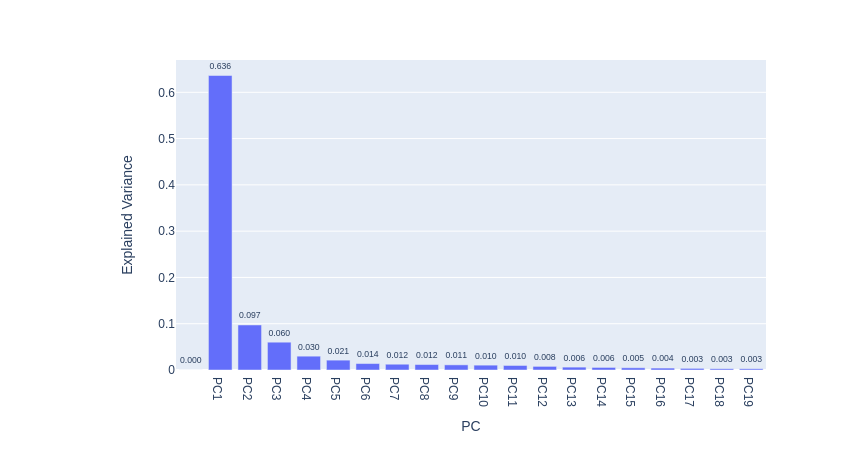

In [134]:
import plotly.express as px

fig = px.bar(df_explained_variance, 
             x='PC', y='Explained Variance',
             text='Explained Variance',
             width=1000)

fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig.show()

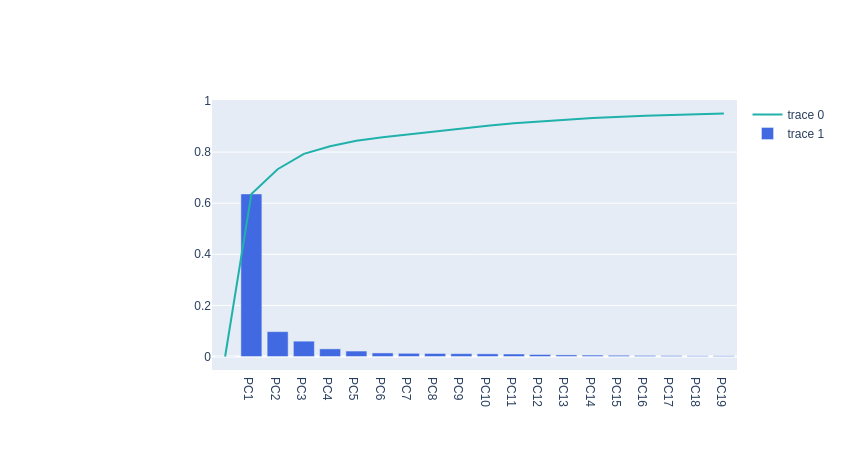

In [135]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_explained_variance['PC'],
        y=df_explained_variance['Cumulative Variance'],
        marker=dict(size=10, color="LightSeaGreen")
    ))

fig.add_trace(
    go.Bar(
        x=df_explained_variance['PC'],
        y=df_explained_variance['Explained Variance'],
        marker=dict(color="RoyalBlue")
    ))

fig.show()

In [136]:
y_train = y_train.reset_index(drop=True)

In [137]:
column_pca = []

for i in range(0,19):
    column_pca.append('PC'+ str(i+1))

len(column_pca)

19

In [138]:
# Buscar correlación entre algún PC y la variable a prededir: precio y seleccionar así los PC con los que quedarme.

pc_df = pd.DataFrame(data=X_train_nuevo, columns=column_pca)
#y_train
df_corr = pd.concat([pc_df, y_train], axis=1)
df_corr.head()


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,price
0,-1.227167,-0.029881,0.579920,-0.249053,-0.161315,-0.048379,-0.014748,-0.055924,-0.067458,0.165321,0.043507,-0.496330,-0.583551,-0.549348,0.151319,-0.126106,0.095314,0.024208,0.001047,175000.0
1,3.378325,0.076921,0.509976,0.867159,-0.189832,0.830180,-0.560397,-0.385186,0.000141,-0.141134,-0.269429,0.076834,0.031197,-0.063775,0.015432,-0.029061,0.046349,0.005043,-0.015866,225000.0
2,1.168034,1.395825,-0.807494,-0.209955,-0.174609,-0.463408,-0.429299,0.567348,0.309295,-0.182546,-0.052296,0.150663,0.028233,-0.055058,0.024501,-0.009227,0.023868,-0.003506,-0.007680,185000.0
3,-1.757790,-0.028922,0.053552,-0.010901,-0.110615,-0.008237,0.172145,0.157801,-0.017366,0.138173,0.100375,-0.068399,-0.051341,0.072504,-0.044441,0.072126,-0.103943,-0.007597,0.000298,72000.0
4,-0.194787,0.668962,-0.299889,-0.192191,-0.098349,-0.071609,0.022775,-0.053948,-0.063957,0.020024,0.067139,-0.178583,-0.028564,0.177249,-0.197222,0.654091,0.679601,0.024709,-0.007186,214900.0


In [139]:

corr = df_corr.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,price
PC1,1.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.73
PC2,-0.00,1.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.20
PC3,0.00,-0.00,1.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.18
PC4,-0.00,-0.00,-0.00,1.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.20
PC5,-0.00,0.00,0.00,0.00,1.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.14
PC6,0.00,0.00,-0.00,-0.00,-0.00,1.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.03
PC7,0.00,-0.00,0.00,-0.00,-0.00,-0.00,1.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.02
PC8,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,1.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.03
PC9,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,1.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.10
PC10,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,1.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.03


Se observa correlación entre PC1 y la variable 'price' que es nuestro target. Por lo tanto, se decide sumar solamente el PC1 al dataset.

In [140]:
# Concatenamos PC1 con el set de train

dfPC1 = df_corr['PC1']
X_train_final = pd.concat([dfPC1, X_train_new], axis=1) # Sumamos PC1 al dataframe con las features transformadas
X_train_final.head() # Set de train final a utilizar en los modelos predictivos

,PC1,ohe__x0_Abasto,ohe__x0_Agronomía,ohe__x0_Almagro,ohe__x0_Balvanera,ohe__x0_Barracas,ohe__x0_Barrio Norte,ohe__x0_Belgrano,ohe__x0_Boca,ohe__x0_Boedo,...,ohe__x0_Villa Urquiza,ohe__x0_Villa del Parque,ohe__x1_Casa,ohe__x1_Departamento,ohe__x1_PH,rooms,bedrooms,bathrooms,surface_total,surface_covered
0,-1.227167,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-0.726708,-0.933934,-0.612749,-0.237720,-0.259220
1,3.378325,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.239412,1.417577,1.142910,1.474717,2.067975
2,1.168034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.239412,1.417577,-0.612749,0.190389,0.185684
3,-1.757790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,-0.726708,-0.933934,-0.612749,-0.637289,-0.977913
4,-0.194787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.256352,0.241822,-0.612749,-0.294802,-0.122327


In [141]:
PC1_test = X_test_pca_df[['PC1']]
X_test_final = pd.concat([PC1_test, X_test_new], axis=1) # Set de test final a utilizar en los modelos predictivos


**Modeling: Decision Tree**

Entrenamos un modelo de árboles de decisión utilizando los features transformados. Luego, compararemos los resultados obtenidos con el modelo entrenado en el proyecto 1.

In [142]:
from sklearn.tree import DecisionTreeRegressor
tree_regressor = DecisionTreeRegressor(max_depth=10, random_state=42)

In [143]:
tree_regressor.fit(X_train_final, y_train)

DecisionTreeRegressor(max_depth=10, random_state=42)

In [144]:
y_pred_train_tree_regressor = tree_regressor.predict(X_train_final)
y_pred_test_tree_regressor = tree_regressor.predict(X_test_final)

In [145]:
from sklearn.metrics import mean_squared_error
print('Metricas de evaluación para el modelo de árboles de decisión')
print('Evaluación sobre el conjunto de test')
r2_test_treep2 =tree_regressor.score(X_test_final, y_test)
print("R^2: {}".format(tree_regressor.score(X_test_final, y_test)))
rmse_test_treep2 = np.sqrt(mean_squared_error(y_test, y_pred_test_tree_regressor))
print("Root Mean Squared Error: {}".format(rmse_test_treep2))

print("\n")

print('Evaluación sobre el conjunto train')
print("R^2: {}".format(tree_regressor.score(X_train_final, y_train)))
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train_tree_regressor))
print("Root Mean Squared Error: {}".format(rmse))

Metricas de evaluación para el modelo de árboles de decisión
Evaluación sobre el conjunto de test
R^2: 0.7688290321267078
Root Mean Squared Error: 44473.88107113265


Evaluación sobre el conjunto train
R^2: 0.7905992993692137
Root Mean Squared Error: 42522.75645199219


In [146]:
#Optimización modelo árboles de decisión

# Definimos las listas vacias para los valores de accuracy deseados
lista_rmse_train = []
lista_rmse_test = []

# Definimos la lista de valores de max_depth que vamos a explorar
max_depths = np.arange(1,20)

# Generamos en loop sobre los distintos valores de profundidad 
for max_depth in max_depths:
    
    # Vamos a repetir el siguiente bloque de código
    
    # Definir el modelo con el valor de profundidad
    tree_regressor = DecisionTreeRegressor(max_depth = max_depth, random_state=42)
    
    # Entrenar el modelo
    tree_regressor.fit(X_train_final,y_train)
    
    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred = tree_regressor.predict(X_train_final)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred)) 
    
    # Predecir y evaluar sobre el set de evaluación
    y_test_pred = tree_regressor.predict(X_test_final)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Agregar la información a las listas
    lista_rmse_train.append(train_rmse)
    lista_rmse_test.append(test_rmse)

Text(0, 0.5, 'RMSE')

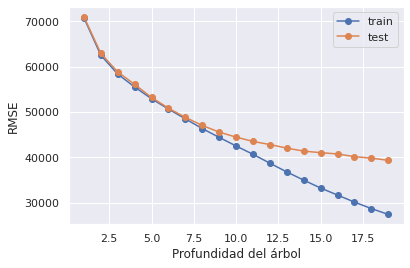

In [147]:
plt.plot(max_depths,lista_rmse_train,'o-',label='train' )
plt.plot(max_depths,lista_rmse_test,'o-',label='test')
plt.legend()
plt.xlabel('Profundidad del árbol')
plt.ylabel('RMSE')

En el proyecto 1 utilizamos una profundidad del árbol de 8. Utilizando los features transformados en este caso observamos que con una profundidad de 8 no es suficiente ya que se underfitea. A continuación compararemos las métricas de ambos modelos.

In [148]:
row = []
dic_arbolesp1 = {'modelo': 'Arboles_de_decision_p1', 'RMSE':158244.21, 'R2':0.73}
dic_arbolesp2 = {'modelo': 'Arboles_de_decision_p2', 'RMSE':rmse_test_treep2.round(2), 'R2': r2_test_treep2.round(2)}
row.append(dic_arbolesp1)
row.append(dic_arbolesp2)

MLA_compare = pd.DataFrame.from_dict(row, orient='columns')
MLA_compare = MLA_compare.sort_values(by='RMSE', ignore_index=True)
MLA_compare


,modelo,RMSE,R2
0,Arboles_de_decision_p2,44473.88,0.77
1,Arboles_de_decision_p1,158244.21,0.73


#### **Conclusiones parciales**

Como conclusiones parciales de esta parte podemos decir que al implementar transformaciones de las variables predictoras obtenemos un modelo con menor error. Demostramos como la utilización de variables categóricas encodeadas, la imputación de valores faltantes y el escalado de las variables numéricas, puede mejorar drásticamente el modelo a implementar.

### Parte B. Modelos avanzados.

En esta parte se entrenaran modelos avanzados con el objetivo de seleccionar el que tenga mejor performance. 

In [149]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

**Simple Linear Regression - Benchmark**


In [150]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_final, y_train)

y_train_pred_1 = lin_reg.predict(X_train_final)
y_test_pred_1 = lin_reg.predict(X_test_final)


MSEs = cross_val_score(lin_reg, X_train_final, y_train, scoring='neg_mean_squared_error', cv=10)
mean_MSE = np.mean(MSEs)
mean_RMSE = np.sqrt(-mean_MSE)
r2 = r2_score(y_test, y_test_pred)

print('RMSE: ', mean_RMSE)
print('R2:' ,r2)

RMSE:  45833.14022267072
R2: 0.8189739710406505


In [151]:
# almacenamos nombre del modelo y metricas

dic_reg_lin = {'modelo': 'Regresion_lineal_simple', 'RMSE':mean_RMSE.round(2), 'R2':r2.round(2)}

row.append(dic_reg_lin)

**Lasso Regression - Feature importance**

In [152]:
from sklearn import linear_model

In [153]:
model_lasso = linear_model.Lasso(tol=0.1)

alpha = [0.0, 0.005, 0.01, 0.5, 1, 1.5, 2, 5, 10]
parameters = {'alpha': alpha}
lasso_regressor = RandomizedSearchCV(model_lasso, param_distributions=parameters, scoring='neg_mean_squared_error', random_state=42, cv=5, verbose=1, n_jobs=-1, return_train_score=True, n_iter=9)
lasso_regressor.fit(X_train_final, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   52.7s finished


RandomizedSearchCV(cv=5, estimator=Lasso(tol=0.1), n_iter=9, n_jobs=-1,
                   param_distributions={'alpha': [0.0, 0.005, 0.01, 0.5, 1, 1.5,
                                                  2, 5, 10]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error', verbose=1)

In [154]:
lasso_regressor.best_params_

{'alpha': 2}

In [155]:
model_lasso = linear_model.Lasso(alpha=2, max_iter=10000, random_state=42, tol=0.1)
model_lasso.fit(X_train_final, y_train)

Lasso(alpha=2, max_iter=10000, random_state=42, tol=0.1)

In [156]:
y_train_pred_lasso = model_lasso.predict(X_train_final)
y_test_pred_lasso = model_lasso.predict(X_test_final)

In [157]:
### CALCULAMOS EL ERROR
rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))
rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_test_pred_lasso))

In [158]:
print(f'Raíz del error cuadrático medio en Train: {rmse_train_lasso}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test_lasso}')
r2_lasso = r2_score(y_test, y_test_pred_lasso).round(2)
print('R2:' ,r2_score(y_test, y_test_pred_lasso).round(2))

Raíz del error cuadrático medio en Train: 45066.350906665204
Raíz del error cuadrático medio en Test: 44935.24942677728
R2: 0.76


In [159]:
dic_lasso = {'modelo': 'Lasso', 'RMSE':rmse_test_lasso.round(2), 'R2':r2_lasso.round(2)}

row.append(dic_lasso)

**Ridge Regression**

In [160]:
ridge = Ridge()

In [161]:
alpha = [0.0, 0.5, 1, 1.5]
parameters = {'alpha': [0.0, 0.5, 1, 1.5]}
ridge_regressor = RandomizedSearchCV(ridge, param_distributions=parameters, scoring='neg_mean_squared_error', random_state=42, cv=5, verbose=1, n_jobs=-1, return_train_score=True)
ridge_regressor.fit(X_train_final, y_train)

/home/seba/anaconda3/envs/DS/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning:

The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.1s finished


RandomizedSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
                   param_distributions={'alpha': [0.0, 0.5, 1, 1.5]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error', verbose=1)

In [162]:
ridge_regressor.best_params_

{'alpha': 1}

In [163]:
ridge_regressor.best_score_ # Best MSE

-2036415996.4923615

In [164]:
y_train_pred_ridge = ridge_regressor.predict(X_train_final)
y_test_pred_ridge = ridge_regressor.predict(X_test_final)

In [165]:
### CALCULAMOS EL ERROR
rmse_train_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
rmse_test_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))

In [166]:
print(f'Raíz del error cuadrático medio en Train: {rmse_train_ridge}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test_ridge}')
r2_ridge = r2_score(y_test, y_test_pred_ridge).round(2)
print('R2:' ,r2_score(y_test, y_test_pred_ridge).round(2))


Raíz del error cuadrático medio en Train: 45065.345462103905
Raíz del error cuadrático medio en Test: 44934.452437080654
R2: 0.76


In [167]:
dic_ridge = {'modelo': 'Ridge', 'RMSE':rmse_test_ridge.round(2), 'R2':r2_ridge.round(2)}
row.append(dic_ridge)

**Random Forest**

In [168]:
from sklearn.ensemble import RandomForestRegressor

In [169]:
RF = RandomForestRegressor(random_state = 42)

In [170]:
param_grid = {
    "n_estimators" : [47, 48, 48.5, 49, 50],
    "max_depth" : [50, 100, 120, 140, 160, 180, 200, 500, 1000],
    "max_features" : ["auto","sqrt", "log2"],
    "bootstrap" : [True, False],
            }

In [171]:
RF_reg = RandomizedSearchCV(RF, param_grid, n_jobs=-1, cv=5, scoring='neg_mean_squared_error', random_state=42, n_iter=40, verbose=1, return_train_score=True)

In [85]:
RF_reg.fit(X_train_final, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 14.0min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [50, 100, 120, 140, 160,
                                                      180, 200, 500, 1000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [47, 48, 48.5, 49, 50]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error', verbose=1)

In [86]:
MSE = RF_reg.best_score_ # -MSE
RMSE = np.sqrt(-MSE)
print('MSE:', MSE, 'RMSE:', RMSE)

MSE: -1079499514.526995 RMSE: 32855.73792394557


In [87]:
RF_reg.best_params_

{'n_estimators': 50,
 'max_features': 'log2',
 'max_depth': 200,
 'bootstrap': True}

En función de la selección de hiperparámetros que hizo RandomizedSearch, realizamos una optimización de hiperparámetros más ajustada utilizando GridSearch.

In [172]:
parameters = {
    "n_estimators" : [48, 49, 50, 51],
    "max_depth" : [180, 190, 200, 210, 220],
    "max_features" : ["sqrt", "log2"],
    "bootstrap" : [True, False],
    }

In [173]:
RF_gs = GridSearchCV(estimator=RF, param_grid=parameters, cv=10, verbose=2, n_jobs=-1, scoring='neg_mean_squared_error')

In [ ]:
#RF_gs.fit(X_train_final, y_train) # Si se quiere entrenar nuevamente descomentar esta línea

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 46.0min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 59.7min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_job

In [174]:
from joblib import dump, load
#dump(RF_gs, 'RF_gs_md180_nest51.joblib')

In [175]:
RF_gs = load('RF_gs_md180_nest51.joblib')

/home/seba/anaconda3/envs/DS/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator DecisionTreeRegressor from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.

/home/seba/anaconda3/envs/DS/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator RandomForestRegressor from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.

/home/seba/anaconda3/envs/DS/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator GridSearchCV from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.



In [176]:
RF_gs.best_params_


{'bootstrap': True,
 'max_depth': 180,
 'max_features': 'log2',
 'n_estimators': 51}

In [177]:
y_test_pred_rf = RF_gs.predict(X_test_final)
y_train_pred_rf = RF_gs.predict(X_train_final)

In [178]:
### CALCULAMOS EL ERROR
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))

In [179]:
print(f'Raíz del error cuadrático medio en Train: {rmse_train_rf}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test_rf}')
r2_rf = r2_score(y_test, y_test_pred_rf)
print('R2:' ,r2_rf)

Raíz del error cuadrático medio en Train: 17285.661422235877
Raíz del error cuadrático medio en Test: 32078.38499507356
R2: 0.8797325171991153


In [180]:
dic_RF = {'modelo':'Random_Forest', 'RMSE':rmse_test_rf.round(2), 'R2':r2_rf.round(2)}
row.append(dic_RF)

**XGBoost**


In [181]:
import xgboost as xgb
#from scipy.stats import uniform, randint

In [182]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

El tuneo de hiperparámetros para este modelo se llevó a cabo de manera secuencial. Primero se buscó los mejores valores para max_depth y min_child_weigth. Luego se siguió con colsample_bytree y min_samples_leaf; luego gamma y finalmente se buscó bajar learning_rate.

In [183]:
params_xgb_1 = {
    "max_depth": [8,9,10],
    "min_child_weight" : [1,2,3],
    "tree_method": ["hist"],
    "colsample_bytree": [0.87],
    "learning_rate" : [0.45],
    "gamma" : [0.01],
    "n_estimators": [133],
    "reg_lambda": [1.2],
    "subsample": [0.97],
    "reg_alpha": [1.2],
}

params_xgb_2 = {
    "max_depth": [9,10],
    "min_child_weight" : [1],
    "colsample_bytree": [0.86,0.87,0.88],
    "min_samples_leaf" : range(200,1001,200),
    "learning_rate": [0.45],
    "gamma" : [0.01],
    "n_estimators": [133],
    "reg_lambda": [1.2],
    "subsample": [0.97,0.98],
    "reg_alpha": [1.1],
    "tree_method": ["hist"]

}

params_xgb_3 = {
    "max_depth": [9,10,11],
    "min_child_weight" : [1],
    "colsample_bytree": [0.88],
    "min_samples_leaf" : [200,250],
    "learning_rate": [0.45],
    "gamma" : [i/10.0 for i in range(0,5)],
    "n_estimators": [133],
    "reg_lambda": [1.2],
    "subsample": [0.98],
    "reg_alpha": [1.1],
    "tree_method": ["hist"]

}

params_xgb_4 = {
    "max_depth": [10],
    "min_child_weight" : [1],
    "colsample_bytree": [0.88],
    "min_samples_leaf" : [200],
    "learning_rate": [0.01, 0.3], #buscamos bajar learning_rate
    "gamma" : [0.0],
    "n_estimators": [133],
    "reg_lambda": [1.1],
    "subsample": [0.97],
    "reg_alpha": [1.2],
    "tree_method": ["hist"],
    "seed" : [2]

}

In [184]:
xgb_model_rs = GridSearchCV(estimator=xgb_model, param_grid=params_xgb_4, cv=10, verbose=2, n_jobs=-1)

In [185]:
xgb_model_rs.fit(X_train_final, y_train)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   53.8s finished


[12:37:46] WARNING: ../src/learner.cc:516: 
Parameters: { min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs...
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.88], 'gamma'

In [186]:
xgb_model_rs.best_params_

{'colsample_bytree': 0.88,
 'gamma': 0.0,
 'learning_rate': 0.3,
 'max_depth': 10,
 'min_child_weight': 1,
 'min_samples_leaf': 200,
 'n_estimators': 133,
 'reg_alpha': 1.2,
 'reg_lambda': 1.1,
 'seed': 2,
 'subsample': 0.97,
 'tree_method': 'hist'}

In [187]:
xgb_model_rs.best_score_

0.8733841056105179

In [188]:
y_test_pred_xgb = xgb_model_rs.predict(X_test_final)
y_train_pred_xgb = xgb_model_rs.predict(X_train_final)

In [189]:
### CALCULAMOS EL ERROR
rmse_train_xgb = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))


In [190]:
print(f'Raíz del error cuadrático medio en Train: {rmse_train_xgb}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test_xgb}')
r2_xgb = r2_score(y_test, y_test_pred_xgb)
print('R2:' ,r2_xgb)

Raíz del error cuadrático medio en Train: 20983.32669879036
Raíz del error cuadrático medio en Test: 33095.721175829756
R2: 0.8719832113053722


In [191]:
dic_xgb = {'modelo':'XGBoost', 'RMSE':rmse_test_xgb.round(2), 'R2':r2_xgb.round(2) }
row.append(dic_xgb)

#### **Comparación de modelos**

In [192]:
MLA_compare = pd.DataFrame.from_dict(row, orient='columns')
MLA_compare = MLA_compare.sort_values(by='RMSE', ignore_index=True)
MLA_compare


,modelo,RMSE,R2
0,Random_Forest,32078.38,0.88
1,XGBoost,33095.72,0.87
2,Arboles_de_decision_p2,44473.88,0.77
3,Ridge,44934.45,0.76
4,Lasso,44935.25,0.76
5,Regresion_lineal_simple,45833.14,0.82
6,Arboles_de_decision_p1,158244.21,0.73


Observamos que el modelo con menor RMSE es RandomForest. Sin embargo, XGBoost tiene un desempeño semejante. Si tuviera que elegir uno me quedaría con RandomForest dado que, más allá de que posee mejores métricas, es mucho más facil de tunear sus hiperparámetros y el tiempo consumido en este proceso es menor.
Por otra parte, se observa que los modelos basados en árboles poseen una mejor performance que los modelos basados en regresión lineal.

#### **Conclusiones parciales**

Se implementaron modelos avanzados para predecir el precio de venta de una propiedad en función de sus características. Los modelos que mejor desempeño obtuvieron fueron XGBoost y RandomForest. 

## Parte C. Interpretación de modelos

A continuación se analizarán e interpretarán los dos mejores modelos obtenidos anteriormente.

**XGBoost**

1) Feature Importance

In [110]:
XGBoost_importance = xgb_model_rs.best_estimator_.feature_importances_

In [111]:
column = X_train_final.columns.tolist()
xgb_coef_list = XGBoost_importance.tolist()

dic_coef_xgb = {}
for name, coef in zip(column, xgb_coef_list):
  dic_coef_xgb[name] = coef

In [112]:
df_xgb = pd.DataFrame(dic_coef_xgb, index=[0])
df_xgb = pd.melt(df_xgb,value_vars=df_xgb.columns) 
df_xgb.sort_values(by='value', inplace=True,ascending=False)

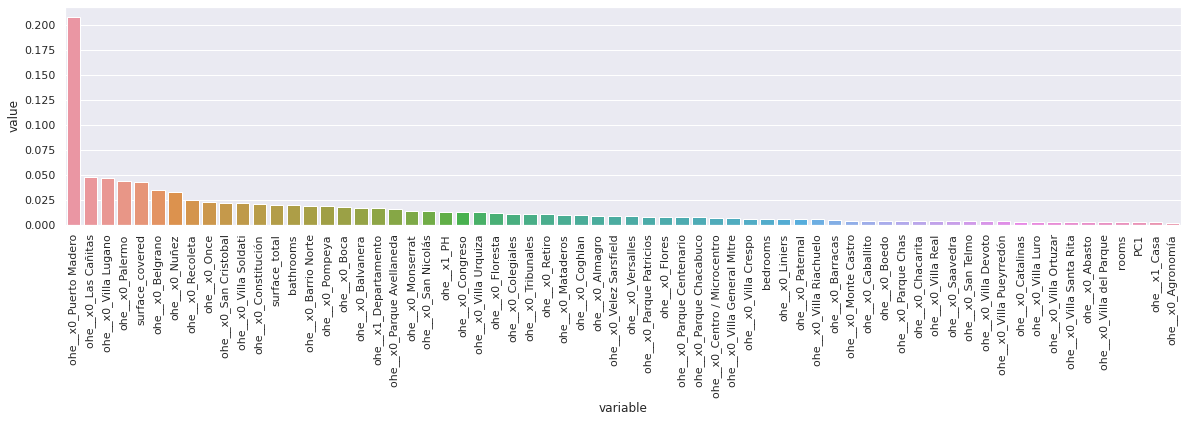

In [113]:
plt.figure(figsize = (20,4))

sns.barplot(x='variable', y='value', data=df_xgb)

plt.xticks(rotation=90)
plt.show()

Se observa que para XGBoost la variable de mayor importancia es ohe_x0_Puerto Madero.

2) Análisis de los errores

/home/seba/anaconda3/envs/DS/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/home/seba/anaconda3/envs/DS/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



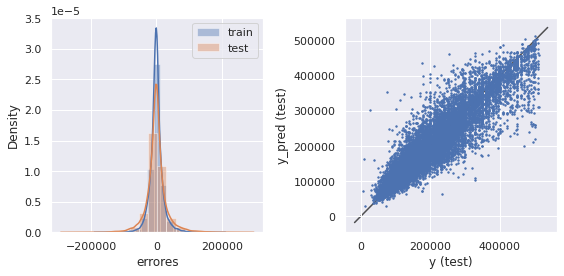

In [114]:
plt.figure(figsize = (8,4))

plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred_xgb, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred_xgb, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()


ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred_xgb, s =2)

lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

plt.tight_layout()
plt.show()

Se observa que los errores poseen una distribución normal, siendo el error en train mayor que el error en test. En cuanto a la variabilidad de los datos predichos versus los reales, observamos como en precios altos hay mayor varianza. No se observa bias.

**Random Forest**

1) Feature importance

In [193]:
RFimportance = RF_gs.best_estimator_.feature_importances_ 

In [194]:
RF_columns = X_train_final.columns.tolist()
RF_coef_list = RFimportance.tolist()

dic_coef_RF = {}
for name, coef in zip(RF_columns, RF_coef_list):
  dic_coef_RF[name] = coef

In [195]:
df_RF=pd.DataFrame(dic_coef_RF, index=[0])
df_RF.head()
df_RF = pd.melt(df_RF,value_vars=df_RF.columns) 

df_RF.sort_values(by='value', inplace=True,ascending=False)


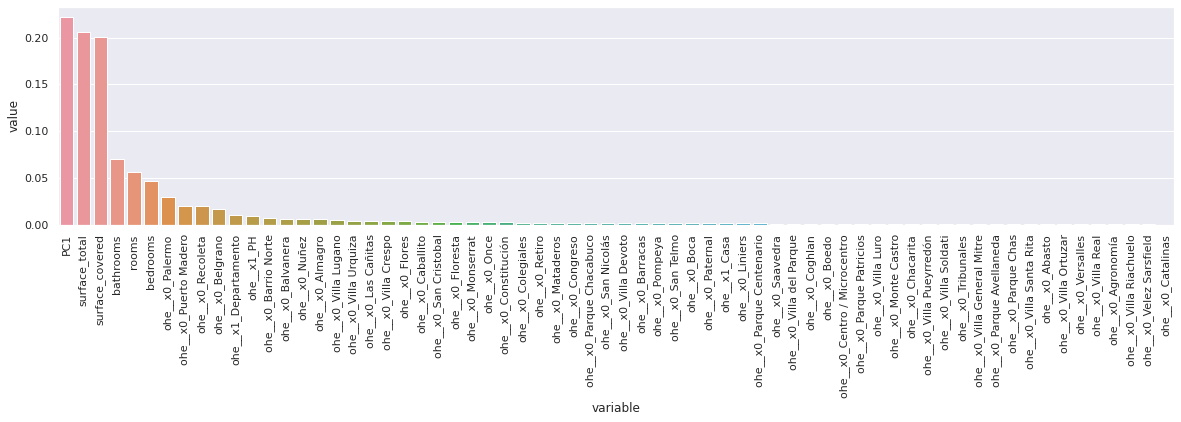

In [196]:
plt.figure(figsize = (20,4))

sns.barplot(x='variable', y='value', data=df_RF)

plt.xticks(rotation=90)
plt.show()

El componente principal PC1, Superficie total y superficie cubierta son las variables que más importancia tienen para Random Forest Regressor. 

2) Analisis del error

/home/seba/anaconda3/envs/DS/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/home/seba/anaconda3/envs/DS/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



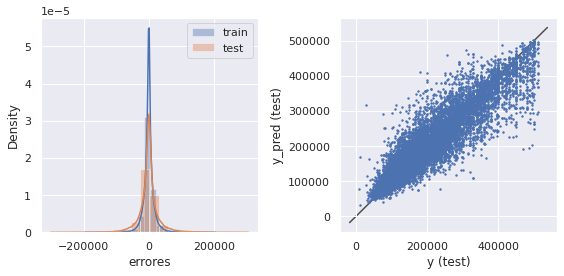

In [197]:
plt.figure(figsize = (8,4))

plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred_rf, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred_rf, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()


ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred_rf, s =2)

lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

plt.tight_layout()
plt.show()

Se observa una distribución normal de los errores, siendo el error en train mayor que el error en test. Para valores más altos de precio hay mayor variabilidad de los datos. No se observa bias.

In [203]:
error = y_test - y_test_pred_rf
df_rf = pd.concat([X_test_final, pd.Series(y_test_pred_rf).reset_index(drop=True), pd.Series(error).reset_index(drop=True)], axis=1)
df_rf.rename({0:'price', 'price':'error'}, axis=1, inplace=True)
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

Vamos a graficar el precio predicho en función de las variables más importantes para el modelo, en busca de patrones relacionales. Queremos observar si, por ejemplo, a mayor precio predicho hay mayor error asociado.

Text(0.5, 1.0, 'Variabilidad del error según PC1')

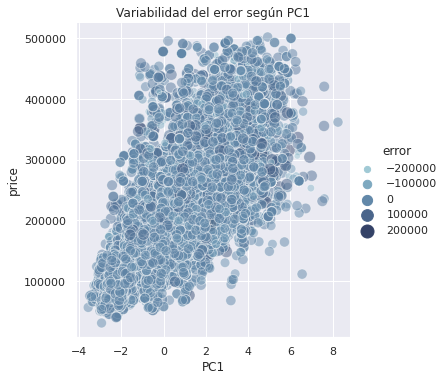

In [204]:
sns.relplot(x='PC1', y='price', hue='error', size='error', sizes=(10,200), data=df_rf, alpha=.5, palette=cmap)
#plt.savefig('suftotvsprice.png')
plt.title('Variabilidad del error según PC1')

Text(0.5, 1.0, 'Variabilidad del error según surface_total')

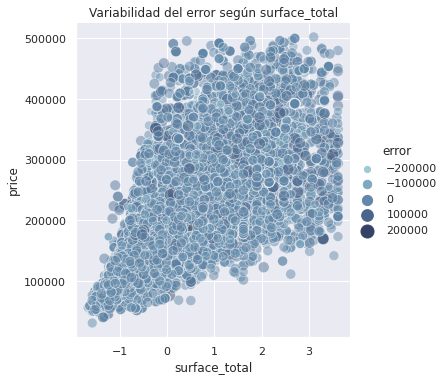

In [205]:
sns.relplot(x='surface_total', y='price', hue='error', size='error', sizes=(10,200), data=df_rf, alpha=.5, palette=cmap)
plt.title('Variabilidad del error según surface_total')

Text(0.5, 1.0, 'Variabilidad del error según surface_covered')

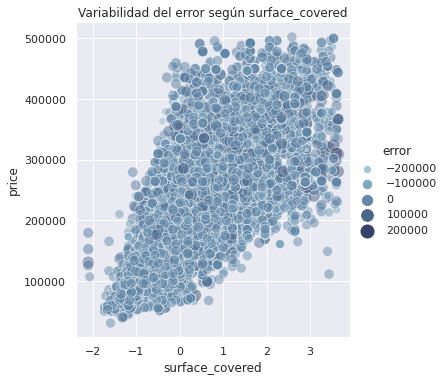

In [206]:
sns.relplot(x='surface_covered', y='price', hue='error', size='error', sizes=(10,200), data=df_rf, alpha=.5, palette=cmap)
plt.title('Variabilidad del error según surface_covered')

No se observa una tendencia clara respecto del error según las variables más importantes para RandomForest. 

In [207]:
selected_tree = RF_gs.best_estimator_.estimators_[50]
selected_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 180,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 1224821422,
 'splitter': 'best'}

Finalmente, podemos decir que ambos modelos presentan una mejora significativa respecto a los modelos simpmles implementados en el proyecto 1. Esto se observa claramente en los gráficos de y_real vs y_pred. En los modelos del proyecto 1 se observaba bias y alta varianza sobre todo en precios altos.

## DESAFIO OPCIONAL : Clustering

In [208]:
from sklearn.cluster import KMeans

In [209]:
df_clustering = df6.copy()

In [210]:
df_clustering.head()

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
0,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH
1,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH
2,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH
3,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,PH
4,Villa Crespo,2.0,1.0,1.0,70.0,70.0,159500.0,PH


In [211]:
X = df_clustering.drop('price', axis=1)
y = df_clustering['price']

In [212]:
# Separamos las features en categóricas y numéricas

X_cat = X[['l3', 'property_type']]
categorical_columns = ['l3', 'property_type']

X_num = X[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']]
numerical_columns = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']

# Encodeamos las variables categóricas 
ct = ColumnTransformer([('ohe', OneHotEncoder(sparse=False), categorical_columns)], remainder='passthrough')
X_cat_ct = ct.fit_transform(X_cat)
X_cat_ct_df = pd.DataFrame(X_cat_ct)
X_cat_ct_df.columns = ct.get_feature_names()
X = pd.concat([X_cat_ct_df, X_num], axis=1)

# Escalamos las variables numéricas
scaler = StandardScaler()
#X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num), columns=numerical_columns)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train = X_train.reset_index(drop=True)
X_train_num = X_train[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']]

X_train_num_scaled = pd.DataFrame(scaler.fit_transform(X_train_num), columns=numerical_columns)
X_train_new = pd.concat([X_train.drop(numerical_columns, axis=1), X_train_num_scaled], axis=1)
X_test = X_test.reset_index(drop=True)
X_test_num = X_test[numerical_columns]
X_test_num_scaled = pd.DataFrame(scaler.transform(X_test_num), columns=numerical_columns)
X_test_new = pd.concat([X_test.drop(numerical_columns, axis=1), X_test_num_scaled], axis=1)

#### **Clustering utilizando KMeans**

Búsqueda de la cantidad óptima de clusters

In [213]:
wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, max_iter=300)
    kmeans.fit(X_train_new)
    wcss.append(kmeans.inertia_)

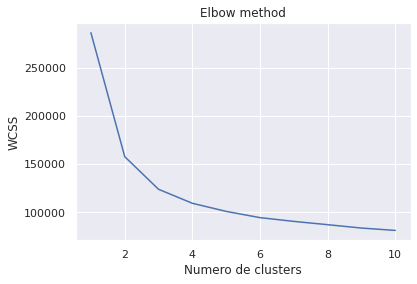

In [214]:
plt.plot(range(1,11), wcss)
plt.title('Elbow method')
plt.xlabel('Numero de clusters')
plt.ylabel('WCSS') #WCSS es un indicador de que tan similares son los individuos dentro de un cluster
plt.show()

El valor de WCSS deja de disminuir de manera drástica cuando el número de clusters es igual o mayor a 3.

In [244]:
model = KMeans(n_clusters=4, max_iter=300)
clusters = model.fit(X_train_new)
etiquetas = clusters.labels_
centros = clusters.cluster_centers_
print(etiquetas)

[0 2 3 ... 0 2 1]


In [245]:
X_train_new['KMeans_clusters'] = etiquetas

In [246]:
X_train_new.head()

,ohe__x0_Abasto,ohe__x0_Agronomía,ohe__x0_Almagro,ohe__x0_Balvanera,ohe__x0_Barracas,ohe__x0_Barrio Norte,ohe__x0_Belgrano,ohe__x0_Boca,ohe__x0_Boedo,ohe__x0_Caballito,...,ohe__x0_Villa del Parque,ohe__x1_Casa,ohe__x1_Departamento,ohe__x1_PH,rooms,bedrooms,bathrooms,surface_total,surface_covered,KMeans_clusters
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,-0.726708,-0.933934,-0.612749,-0.237720,-0.259220,0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.239412,1.417577,1.142910,1.474717,2.067975,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.239412,1.417577,-0.612749,0.190389,0.185684,3
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,-0.726708,-0.933934,-0.612749,-0.637289,-0.977913,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.256352,0.241822,-0.612749,-0.294802,-0.122327,3


#### **Visualizando los clusters formados**

Aplicamos PCA para analizar los clusters formados

In [247]:
pca = PCA(2)
X_train_pca = pca.fit_transform(X_train_new.drop('KMeans_clusters', axis=1))

In [228]:
X_train_pca_df = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2'])
X_train_pca_nombres = pd.concat([X_train_pca_df, X_train_new[['KMeans_clusters']], df_clustering[['l3']] ], axis=1)
X_train_pca_nombres.head()

,PC1,PC2,KMeans_clusters,l3
0,-1.227167,-0.029881,1.0,Boedo
1,3.378325,0.076921,0.0,Palermo
2,1.168034,1.395825,2.0,Palermo
3,-1.757790,-0.028922,1.0,Villa Crespo
4,-0.194787,0.668962,2.0,Villa Crespo


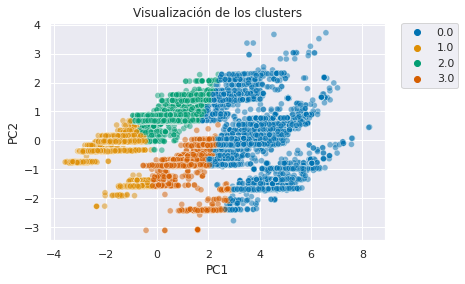

In [230]:
sns.scatterplot(x='PC1', y='PC2', data=X_train_pca_nombres,alpha=0.5, palette='colorblind', hue='KMeans_clusters')
#plt.savefig('proyecto_clustering.png')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Visualización de los clusters')
plt.show()

Observamos que los clusters no logran agrupar los individuos de manera correcta

In [224]:
print(pca.explained_variance_ratio_)

[0.6363097  0.09730297]


In [225]:
pca.explained_variance_

array([3.92218221, 0.59977079])

In [255]:
loadings_cluster = abs(pca.components_.T)
X_train_cluster = X_train_new.drop('KMeans_clusters', axis=1)
df_loadings_cluster = pd.DataFrame(loadings_cluster, columns=["PC1","PC2"], index=X_train_cluster.columns)
df_loadings_cluster.idxmax(axis=0)
#df_loadings_cluster


PC1    surface_covered
PC2          bathrooms
dtype: object

Para PC1 la variable más importante es "surface_covered", mientras que para PC2 es "bathrooms"

In [226]:
def biplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.figure(figsize=(10,7))
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    
    plt.grid()
    plt.show()

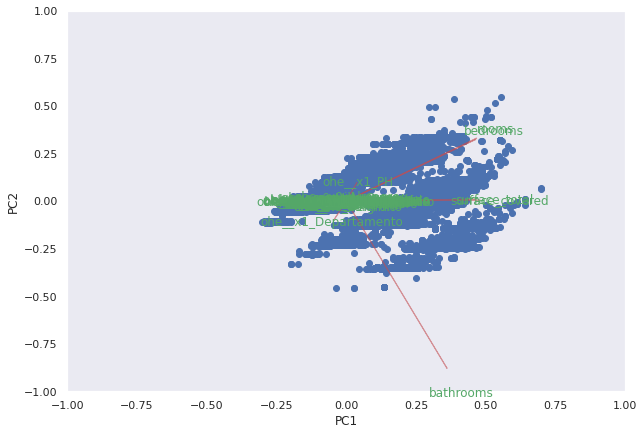

In [227]:
biplot(X_train_pca,np.transpose(pca.components_), labels=X_train_new.columns)

Podemos verificar gráficamente que la variable "bathrooms" es la más importante para PC2. Además, las flechas (variables/características) que apuntan en la misma dirección indican una correlación entre las variables que representan, mientras que las flechas que apuntan en direcciones opuestas indican un contraste entre las variables que representan.

## Conclusiones finales

¿Qué podemos aprender de nuestro problema estudiando los modelos implementados?
En este proyecto se implementaros modelos avanzados para resolver nuestro problema: obtener un modelo que prediga el precio de propiedades (inmuebles). Se logró implementar modelos de regresión lineal como de modelos basados en árboles de decisión. El mejor modelo fue RandomForestRegressor con un RMSE de 32078.38 y un R2 de 0.88. Resultados que superan ampliamente los modelos simples entrenados en el proyecto 1. Para Random Forest, PC1, surface_total y surface_covered son las features más importantes. Esto resulta lógico y coherente ya que el precio de las propiedades depende fuertemente de estas características. La implementación de clusterización utilizando KMeans no arrojó buenos resultados. Se debería probar con otros modelos de clustering para observar si se mejora el agrupamiento de los individuos.